In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.optim as optim

In [4]:
import gdown

# Đặt ID của tệp và tên tệp tải về
file_id = "16tiNjsITbWh-3J5laCgtBX0MaR6cVT2e"
url = f"https://drive.google.com/uc?id={file_id}"
output = r"C:\Users\VIET HOANG - VTS\Desktop\VisionReader\nlp\data.csv"  # Tên tệp tải về

# Tải tệp
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=16tiNjsITbWh-3J5laCgtBX0MaR6cVT2e
To: C:\Users\VIET HOANG - VTS\Desktop\VisionReader\nlp\data.csv
100%|██████████| 15.2M/15.2M [00:02<00:00, 6.32MB/s]


'C:\\Users\\VIET HOANG - VTS\\Desktop\\VisionReader\\nlp\\data.csv'

In [6]:
df = pd.read_csv(output, encoding='ISO-8859-1')
data = df.fillna(method="ffill")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


C:\Users\VIET HOANG - VTS\AppData\Local\Temp\ipykernel_21684\525937010.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = df.fillna(method="ffill")


In [7]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [8]:
tags = list(set(data["Tag"].values))
tags.append("ENDPAD")
num_tags = len(words)

In [9]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [10]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [11]:
word2idx = {w: i   for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [12]:
import matplotlib.pyplot as plt

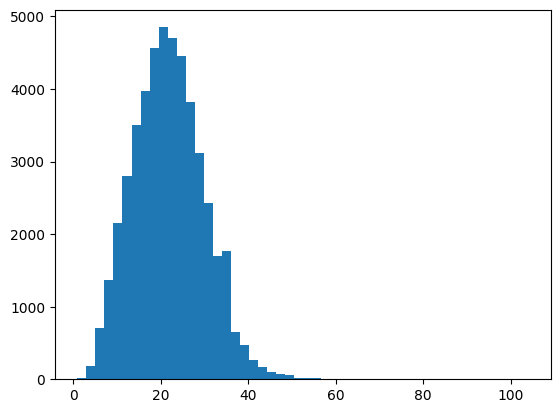

In [13]:
length = [len(s) for s in sentences]
length = np.array(length)
plt.hist(length, bins=50)
plt.show()

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#đặt max length cho phù hợp
max_len = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

X = torch.tensor(X, dtype=torch.long).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [19]:
import torch
import torch.nn as nn

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes, num_layers=1, pad_idx=0):
        super(BiLSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.bilstm = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers,
                              bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.bilstm(embedded)
        logits = self.fc(lstm_out)
        return logits


In [20]:
batch_size = 32
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
model1 = BiLSTM(vocab_size = num_words, embedding_dim= 50, hidden_size = 100, num_classes = num_tags).to(device)
# Initialize optimizer and loss function
optimizer = optim.Adam(model1.parameters(), lr=3e-4)  # Learning rate set to 0.0003
loss_fn = nn.CrossEntropyLoss()

for epoch in range(10):
    print(f"Epoch {epoch + 1}:")
    model1.train()
    for batch_item in tqdm(train_dataloader, desc="training"):
        word, label = batch_item
        word, label = word.to(device), label.to(device)

        outputs = model1(word)
        outputs = outputs.view(-1, outputs.size(-1))  # (batch_size * sequence_length, num_classes)
        labels = label.view(-1)  # (batch_size * sequence_length)

        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


Epoch 1:


training: 100%|██████████| 1199/1199 [01:35<00:00, 12.49it/s]


Epoch 2:


training: 100%|██████████| 1199/1199 [01:40<00:00, 11.91it/s]


Epoch 3:


training: 100%|██████████| 1199/1199 [01:43<00:00, 11.63it/s]


Epoch 4:


training: 100%|██████████| 1199/1199 [01:44<00:00, 11.49it/s]


Epoch 5:


training: 100%|██████████| 1199/1199 [01:46<00:00, 11.29it/s]


Epoch 6:


training: 100%|██████████| 1199/1199 [01:46<00:00, 11.24it/s]


Epoch 7:


training: 100%|██████████| 1199/1199 [01:46<00:00, 11.23it/s]


Epoch 8:


training: 100%|██████████| 1199/1199 [01:47<00:00, 11.18it/s]


Epoch 9:


training: 100%|██████████| 1199/1199 [01:47<00:00, 11.12it/s]


Epoch 10:


training: 100%|██████████| 1199/1199 [01:47<00:00, 11.14it/s]


In [ ]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

model1.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model1(x_batch)
        
        _, predicted = torch.max(outputs, dim=2)
        

        mask = (y_batch != 0)
        filtered_preds = predicted[mask].cpu().numpy()
        filtered_labels = y_batch[mask].cpu().numpy()
        
        all_predictions.extend(filtered_preds)
        all_labels.extend(filtered_labels)

print("Classification Report:")
print(classification_report(all_labels, all_predictions, zero_division=1))


f1_micro = f1_score(all_labels, all_predictions, average='micro')
f1_macro = f1_score(all_labels, all_predictions, average='macro')
accuracy = accuracy_score(all_labels, all_predictions)

print(f"Micro F1-score: {f1_micro}")
print(f"Macro F1-score: {f1_macro}")
print(f"Overall Accuracy: {accuracy}")

Classification Report:
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       0.88      0.61      0.72      1249
           2       0.78      0.10      0.18        70
           3       0.93      0.89      0.91      3137
           4       1.00      0.00      0.00        13
           5       1.00      0.00      0.00        94
           6       0.75      0.62      0.68      4148
           7       1.00      0.24      0.39        33
           8       0.90      0.82      0.86      4074
           9       1.00      0.00      0.00        40
          10       0.99      1.00      0.99    447384
          11       1.00      0.00      0.00        84
          12       0.85      0.83      0.84      3404
          13       0.76      0.69      0.73      3391
          14       0.83      0.85      0.84      7556
          15       1.00      0.00      0.00        65
          16       0.80      0.71      0.75      1461

   

In [25]:
torch.save(model1.state_dict(), 'models/nlp1_model.pth')
print("mo hinh da duoc luu!")

mo hinh da duoc luu!
